### Receiving data, initial processing

Data was downloaded from Globus (globus.org).  It was sent in two zipped files, one from each lane, containing separate files for each sample (demultiplexed). 

I then checked that the md5 values were the same using `md5 [filename].tar.gz >> [filename].md5` (this appened the new value in the .md5 file, so I could compare). 

### A note on data accessibility & my working environment

I originally downloaded data to Ostrich, thinking that I could work on that computer remotely using Remote Desktop and Jupyter Notebook. However, my internet connection is too slow to work productively that way. I therefore also downloaded the data to my external hard drive, and worked locally. This also allows me to use all the packages that I had installed on my personal computer in 2018 (which is helpful). 

Canonical versions of the data is saved to Owl/Nightengales in the zipped format here: [nightingales/O_lurida/2020-04-21_QuantSeq-data/](http://owl.fish.washington.edu/nightingales/O_lurida/2020-04-21_QuantSeq-data/) and as individual fastq/sample here [nightingales/O_lurida/](http://owl.fish.washington.edu/nightingales/O_lurida/), and to Gannet as individual fastq/sample here [Atumefaciens/20200426_olur_fastqc_quantseq/](https://gannet.fish.washington.edu/Atumefaciens/20200426_olur_fastqc_quantseq/). 

Sam also ran MultiQC on my samples; check out his [notebook entry](https://robertslab.github.io/sams-notebook/2020/04/26/FastQC-MultiQC-Laura-Spencer's-QuantSeq-Data.html), and the [MultiQC report](https://gannet.fish.washington.edu/Atumefaciens/20200426_olur_fastqc_quantseq/multiqc_report.html).

### Create path variables, i.e. shortcuts to certain directories 

To start, create some variables for commonly accessed paths. NOTE: many of the steps in this workflow require the me to be located within a specific directory to access files. So, while I try to use these path variables, I often have to hard-code my paths. 

In [3]:
# check working directory 
pwd

'/Users/laura/Documents/roberts-lab/laura-quantseq/notebooks'

In [69]:
# create path variable to github repo 
repo = "Users/laura/Documents/roberts-lab/laura-quantseq/"

In [1]:
# create path variable to raw data, saved on my external hard drive 
workingdir = "/Volumes/Bumblebee/QuantSeq-04-21-2020/"

### Install tag-seq scripts, create {tagseq} variable

I had cloned the tag-based_RNAseq.git repo back in 2018 using the following: 
`git clone https://github.com/z0on/tag-based_RNAseq.git /Users/lhs3/Documents/bioinf/tag-based_RNAseq/`. 

To update the package, I navigated to the directory locally, then did `git pull` and it updated the files. 

In [82]:
# create path variable to tagseq directory 
tagseq = "/Applications/bioinformatics/tag-based_RNAseq/"

In [103]:
# create path variable to fastqc directory 
fastqc = "/Applications/bioinformatics/FastQC/"

In [48]:
# test fqstqc 
! {fastqc}fastqc --help


            FastQC - A high throughput sequence QC analysis tool

SYNOPSIS

	fastqc seqfile1 seqfile2 .. seqfileN

    fastqc [-o output dir] [--(no)extract] [-f fastq|bam|sam] 
           [-c contaminant file] seqfile1 .. seqfileN

DESCRIPTION

    FastQC reads a set of sequence files and produces from each one a quality
    control report consisting of a number of different modules, each one of 
    which will help to identify a different potential type of problem in your
    data.
    
    If no files to process are specified on the command line then the program
    will start as an interactive graphical application.  If files are provided
    on the command line then the program will run with no user interaction
    required.  In this mode it is suitable for inclusion into a standardised
    analysis pipeline.
    
    The options for the program as as follows:
    
    -h --help       Print this help file and exit
    
    -v --version    Print the version of the program and exit

### I installed MultiQC using git clone via the following: 

    git clone https://github.com/ewels/MultiQC.git
    cd MultiQC
    pip install .

In [71]:
# test multiqc 
! multiqc --help

Usage: multiqc [OPTIONS] <analysis directory>

  Main MultiQC run command for use with the click command line, complete
  with all click function decorators. To make it easy to use MultiQC within
  notebooks and other locations that don't need click, we simply pass the
  parsed variables on to a vanilla python function.

Options:
  -f, --force                     Overwrite any existing reports
  -d, --dirs                      Prepend directory to sample names
  -dd, --dirs-depth INTEGER       Prepend [INT] directories to sample names.
                                  Negative number to take from start of path.

  -s, --fullnames                 Do not clean the sample names (leave as full
                                  file name)

  -i, --title TEXT                Report title. Printed as page header, used
                                  for filename if not otherwise specified.

  -b, --comment TEXT              Custom comment, will be printed at the top
                        

### Install Cutadapt 

The [Cutadapt program](https://cutadapt.readthedocs.io/en/stable/installation.html) is used in the tagseq processing pipeline. I installed `cutadapt` using `python3 -m pip install --user --upgrade cutadapt`. During install, I received this warning: 

    WARNING: The script cutadapt is installed in '/Users/laura/.local/bin' which is not on PATH.
    Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  
So, I added that path to my PATH using the following in Terminal:  
`PATH=$PATH:/Users/laura/.local/bin`

For some reason Jupyter Notebook doesn't recognize `cutadapt`, even though I can access it via the Terminal. 

In [109]:
# Try to add the path here 
! PATH=$PATH:/Users/laura/.local/bin

In [113]:
# Still doesn't work 
! cutadapt --version

/bin/sh: cutadapt: command not found


In [114]:
# Hard coding the cutadapt path works, though 
! /Users/laura/.local/bin/cutadapt --version

2.10


In [2]:
# test fastq_quality_filter (see if it's correctly added to my PATH)
! fastq_quality_filter -h

usage: fastq_quality_filter [-h] [-v] [-q N] [-p N] [-z] [-i INFILE] [-o OUTFILE]
Part of FASTX Toolkit 0.0.14 by A. Gordon (assafgordon@gmail.com)

   [-h]         = This helpful help screen.
   [-q N]       = Minimum quality score to keep.
   [-p N]       = Minimum percent of bases that must have [-q] quality.
   [-z]         = Compress output with GZIP.
   [-i INFILE]  = FASTA/Q input file. default is STDIN.
   [-o OUTFILE] = FASTA/Q output file. default is STDOUT.
   [-v]         = Verbose - report number of sequences.
                  If [-o] is specified,  report will be printed to STDOUT.
                  If [-o] is not specified (and output goes to STDOUT),
                  report will be printed to STDERR.



In [29]:
! ls {tagseq}

2bRAD_bowtie2_launch.pl            picogreen.csv
README.md                          rnaseq_clipper0.pl
TagSeq_GSAF_Price.xlsx             rnaseq_clipper_fasta.pl
TagSeq_sample_prep_june2019.docx   rnaseq_clipper_old.pl
countreads.pl                      samcount.pl
dna.mixing.R                       samcount_launch.pl
dupCount.R                         samcount_launch_bt2.pl
expression_compiler.pl             samcount_v.0.1.pl
iRNAseq_shrimpmap_SAM.pl           selectFastaByHeader.pl
iRNAseq_trim_launch0.pl            splitFastaByHeader.pl
illumina_mix_data.csv              tag-seq_scripts_manual.pdf
isogroup_namer.pl                  tagSeq_processing_README.txt
launcher_creator.py                tagseq_bowtie2map.pl
ls5_launcher_creator.py            tagseq_clipper.pl
mix_illumina_qpcr.R                tagseq_oligos_order_192samples.xls
ngs_concat.pl                      tagseq_trim_launch.pl
p5barcodes_order.xlsx              tagseq_trim_launch_bgi.pl
picogreen.R                    

In [9]:
cd {rawdata}

/Volumes/Peach Backup/QuantSeq-04-21-2020


In [10]:
pwd

'/Volumes/Peach Backup/QuantSeq-04-21-2020'

In [11]:
ls

Batch1_69plex_lane1.md5     Batch2_77plex_lane2_md5
Batch1_69plex_lane1.tar.gz  Batch2_77plex_lane2_tar.gz


### Currently, the data is still zipped (that's how it arrived via Globus). I need to thus tar/gunzip the lane files, before I can gunzip the individual library files.  

In [12]:
# extract batch/lane 1 data 
! gunzip -c Batch1_69plex_lane1.tar.gz | tar xopf -

In [13]:
# extract batch/lane 2 data 
! gunzip -c Batch2_77plex_lane2_tar.gz | tar xopf -

In [14]:
# check out resulting file structure 
! ls

Batch1_69plex_lane1.md5    Batch2_77plex_lane2_done
Batch1_69plex_lane1.tar.gz Batch2_77plex_lane2_md5
Batch1_69plex_lane1_done   Batch2_77plex_lane2_tar.gz


In [15]:
! ls Batch1_69plex_lane1_done/

137_S63_L001_R1_001.fastq.gz         314_S49_L001_R1_001.fastq.gz
139_S54_L001_R1_001.fastq.gz         315_S26_L001_R1_001.fastq.gz
140_S64_L001_R1_001.fastq.gz         316_S9_L001_R1_001.fastq.gz
141_S61_L001_R1_001.fastq.gz         317_S33_L001_R1_001.fastq.gz
156_S66_L001_R1_001.fastq.gz         318_S6_L001_R1_001.fastq.gz
159_S68_L001_R1_001.fastq.gz         319_S52_L001_R1_001.fastq.gz
161_S57_L001_R1_001.fastq.gz         321_S29_L001_R1_001.fastq.gz
162_S62_L001_R1_001.fastq.gz         322_S8_L001_R1_001.fastq.gz
168_S67_L001_R1_001.fastq.gz         323_S39_L001_R1_001.fastq.gz
169_S65_L001_R1_001.fastq.gz         324_S47_L001_R1_001.fastq.gz
171_S58_L001_R1_001.fastq.gz         325_S13_L001_R1_001.fastq.gz
172_S59_L001_R1_001.fastq.gz         326_S38_L001_R1_001.fastq.gz
181_S69_L001_R1_001.fastq.gz         327_S37_L001_R1_001.fastq.gz
183_S56_L001_R1_001.fastq.gz         328_S12_L001_R1_001.fastq.gz
184_S55_L001_R1_001.fastq.gz         329_S46_L001_R1_001.fastq.gz
185_S60_L001_

### Move to each batch's directory containing demultiplexed library files, and gunzip all fastq files in that folder

In [18]:
cd Batch1_69plex_lane1_done/

/Volumes/Peach Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done


In [19]:
! gunzip *.fastq.gz

In [21]:
cd ../Batch2_77plex_lane2_done/

/Volumes/Peach Backup/QuantSeq-04-21-2020/Batch2_77plex_lane2_done


In [22]:
! gunzip *.fastq.gz 

In [23]:
# Check out contents after gunzip 
! ls 

34_S68_L002_R1_001.fastq          482_S25_L002_R1_001.fastq
35_S72_L002_R1_001.fastq          483_S7_L002_R1_001.fastq
37_S70_L002_R1_001.fastq          484_S43_L002_R1_001.fastq
39_S52_L002_R1_001.fastq          485_S21_L002_R1_001.fastq
401_S10_L002_R1_001.fastq         487_S6_L002_R1_001.fastq
402_S5_L002_R1_001.fastq          488_S26_L002_R1_001.fastq
403_S30_L002_R1_001.fastq         489_S35_L002_R1_001.fastq
404_S42_L002_R1_001.fastq         490_S19_L002_R1_001.fastq
411_S9_L002_R1_001.fastq          491_S50_L002_R1_001.fastq
412_S74_L002_R1_001.fastq         492_S40_L002_R1_001.fastq
413_S38_L002_R1_001.fastq         506_S47_L002_R1_001.fastq
414_S49_L002_R1_001.fastq         513_S56_L002_R1_001.fastq
41_S62_L002_R1_001.fastq          521_S65_L002_R1_001.fastq
421_S22_L002_R1_001.fastq         522_S1_L002_R1_001.fastq
431b_S8_L002_R1_001.fastq         523_S4_L002_R1_001.fastq
432_S75_L002_R1_001.fastq         524_S11_L002_R1_001.fastq
434_S55_L002_R1_001.fastq         525_S18_L0

In [45]:
! mkdir ../fastqc/

In [46]:
! mkdir ../fastqc/untrimmed/

In [49]:
# test fastqc on one sample file 
! {fastqc}fastqc \
506_S47_L002_R1_001.fastq \
--outdir ../fastqc/untrimmed/

Started analysis of 506_S47_L002_R1_001.fastq
Approx 5% complete for 506_S47_L002_R1_001.fastq
Approx 10% complete for 506_S47_L002_R1_001.fastq
Approx 15% complete for 506_S47_L002_R1_001.fastq
Approx 20% complete for 506_S47_L002_R1_001.fastq
Approx 25% complete for 506_S47_L002_R1_001.fastq
Approx 30% complete for 506_S47_L002_R1_001.fastq
Approx 35% complete for 506_S47_L002_R1_001.fastq
Approx 40% complete for 506_S47_L002_R1_001.fastq
Approx 45% complete for 506_S47_L002_R1_001.fastq
Approx 50% complete for 506_S47_L002_R1_001.fastq
Approx 55% complete for 506_S47_L002_R1_001.fastq
Approx 60% complete for 506_S47_L002_R1_001.fastq
Approx 65% complete for 506_S47_L002_R1_001.fastq
Approx 70% complete for 506_S47_L002_R1_001.fastq
Approx 75% complete for 506_S47_L002_R1_001.fastq
Approx 80% complete for 506_S47_L002_R1_001.fastq
Approx 85% complete for 506_S47_L002_R1_001.fastq
Approx 90% complete for 506_S47_L002_R1_001.fastq
Approx 95% complete for 506_S47_L002_R1_001.fastq
Analy

### Run fastqc on all .fastq files in Batch/Lane2, the larval data (current directory) 

In [50]:
! {fastqc}fastqc \
*.fastq \
--outdir ../fastqc/untrimmed/ \
--quiet

In [52]:
# check out resulting fastqc files. 
! ls ../fastqc/untrimmed/

34_S68_L002_R1_001_fastqc.html          481_S57_L002_R1_001_fastqc.html
34_S68_L002_R1_001_fastqc.zip           481_S57_L002_R1_001_fastqc.zip
35_S72_L002_R1_001_fastqc.html          482_S25_L002_R1_001_fastqc.html
35_S72_L002_R1_001_fastqc.zip           482_S25_L002_R1_001_fastqc.zip
37_S70_L002_R1_001_fastqc.html          483_S7_L002_R1_001_fastqc.html
37_S70_L002_R1_001_fastqc.zip           483_S7_L002_R1_001_fastqc.zip
39_S52_L002_R1_001_fastqc.html          484_S43_L002_R1_001_fastqc.html
39_S52_L002_R1_001_fastqc.zip           484_S43_L002_R1_001_fastqc.zip
401_S10_L002_R1_001_fastqc.html         485_S21_L002_R1_001_fastqc.html
401_S10_L002_R1_001_fastqc.zip          485_S21_L002_R1_001_fastqc.zip
402_S5_L002_R1_001_fastqc.html          487_S6_L002_R1_001_fastqc.html
402_S5_L002_R1_001_fastqc.zip           487_S6_L002_R1_001_fastqc.zip
403_S30_L002_R1_001_fastqc.html         488_S26_L002_R1_001_fastqc.html
403_S30_L002_R1_001_fastqc.zip          488_S26_L002_R1_001_fastqc.zip
404

### Run fastqc on all fastq files in Batch/Lane 1, the adult ctenidia+juvenile samples 

In [73]:
cd ../Batch1_69plex_lane1_done/

/Volumes/Peach Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done


In [74]:
! {fastqc}fastqc \
*.fastq \
--outdir ../fastqc/untrimmed/ \
--quiet

### Generate a MultiQC report on all untrimmed data files 

In [78]:
! multiqc {workingdir}fastqc/untrimmed/ --filename multiqc_report_untrimmed.html

[INFO   ]         multiqc : This is MultiQC v1.9.dev0
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Searching   : /Volumes/Peach Backup/QuantSeq-04-21-2020/fastqc/untrimmed
[INFO   ]          fastqc : Found 148 reports
[INFO   ]         multiqc : Compressing plot data
[INFO   ]         multiqc : Report      : multiqc_report_untrimmed.html
[INFO   ]         multiqc : Data        : multiqc_report_untrimmed_data
[INFO   ]         multiqc : MultiQC complete


### Inspect MultiQC report by opening in browser

### summary report
![summary report](https://github.com/fish546-2018/laura-quantseq/blob/master/notebooks/screen-shots/2020-05-07_untrimmed-multiqc-summary.png?raw=true)

### adapter content 
![adapter content](https://github.com/fish546-2018/laura-quantseq/blob/master/notebooks/screen-shots/2020-05-07_untrimmed-multiqc-adapter.png?raw=true)

### per base sequence count
![per base sequence count](https://github.com/fish546-2018/laura-quantseq/blob/master/notebooks/screen-shots/2020-05-07_untrimmed-multiqc-duplicate-base-content.png?raw=true)

### % unique and duplicate reads
![% unique and duplicate reads](https://github.com/fish546-2018/laura-quantseq/blob/master/notebooks/screen-shots/2020-05-07_untrimmed-multiqc-duplicate-percentage.png?raw=true)

# Pipeline development 

## Step 1: Identify set of test data files

I want to test various trimming and aligning methods. I have 144 samples, so it would be foolish to test my pipeline on all of them. I want to instead select a few samples of differing quality and from different tissue types (pooled larvae, adult ctenidia, juvenile whole body). 

- **Samples 291-349** = adult ctenidia tissue   
- **Samples 137-185** = juvenile whole body  
- **Samples 401-565 and 34-47** = larvae (pooled by "family"). Note: no. 34-47 were previously sequenced in my pilot QuantSeq run, and I re-ran them here. The library quality was relatively low compared to other samples.  
- **Sample 571** = no tissue control (went through whole library prep process)  

Upon inspecting the MultiQC report and taking the sample type in to consideration, the following are my test batch of samples:
- 141  
- 159  
- 302  
- 331  
- 34  
- 441  
- 483  
- 563  

First I make a directory within my raw-data directory, and move the test batch of files there.  

In [109]:
! mkdir {workingdir}raw-data/test-batch/

In [115]:
! cp -v /Volumes/Peach\ Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done/141_S61_L001_R1_001.fastq {workingdir}raw-data/test-batch/ \
cp -v /Volumes/Peach\ Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done/159_S68_L001_R1_001.fastq {workingdir}raw-data/test-batch/ \
cp -v /Volumes/Peach\ Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done/302_S15_L001_R1_001.fastq {workingdir}raw-data/test-batch/ \
cp -v /Volumes/Peach\ Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done/331_S53_L001_R1_001.fastq {workingdir}raw-data/test-batch/ \
cp -v /Volumes/Peach\ Backup/QuantSeq-04-21-2020/Batch2_77plex_lane2_done/34_S68_L002_R1_001.fastq {workingdir}raw-data/test-batch/ \
cp -v /Volumes/Peach\ Backup/QuantSeq-04-21-2020/Batch2_77plex_lane2_done/441_S73_L002_R1_001.fastq {workingdir}raw-data/test-batch/ \
cp -v /Volumes/Peach\ Backup/QuantSeq-04-21-2020/Batch2_77plex_lane2_done/483_S7_L002_R1_001.fastq {workingdir}raw-data/test-batch/ \
cp -v /Volumes/Peach\ Backup/QuantSeq-04-21-2020/Batch2_77plex_lane2_done/563_S59_L002_R1_001.fastq {workingdir}raw-data/test-batch/

/Volumes/Peach Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done/141_S61_L001_R1_001.fastq -> /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/141_S61_L001_R1_001.fastq
cp: /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch and /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/ are identical (not copied).
cp: cp: No such file or directory
cp: -v: No such file or directory
/Volumes/Peach Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done/159_S68_L001_R1_001.fastq -> /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/159_S68_L001_R1_001.fastq
cp: /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch and /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/ are identical (not copied).
cp: cp: No such file or directory
cp: -v: No such file or directory
/Volumes/Peach Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done/302_S15_L001_R1_001.fastq -> /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/302_S15_L001_R1_001.fastq
cp: /Volume

###  What adapters do I need to trim off? 

According to the QuantSeq FAQ section ["1.13 What sequence should be trimmed?"](https://www.lexogen.com/quantseq-3mrna-sequencing/#c873a9746c24c41e7): 

_The reads should be trimmed to remove adapter sequences, poly(A) / poly(T) sequences, and low quality nucleotides. Reads that are too short (i.e., <20 nt) or have generally low quality scores should be removed from the set._

_As second strand synthesis is based on random priming, there may be a higher proportion of errors at the first nucleotides of the insert due to non-specific hybridization of the random primer to the cDNA template. For QuantSeq FWD data we therefore recommend using an aligner that can perform soft-clipping of the read ends (e.g., STAR aligner) during alignment, or increasing the number of allowed mismatches to 14. Alternatively, trimming the first 12 nt of Read 1 can be performed prior to alignment when using a more stringent aligner (e.g., HISAT2). While trimming the read can decrease the number of reads of suitable length for alignment, the absolute number of mapping reads may increase due to the improved read quality._

As a reminder, here is how the QuantSeq libraries were generated: 
![read_orientation_schematic](https://github.com/fish546-2018/laura-quantseq/blob/master/references/QuantSeq_library_generation_schematic.png?raw=true)

It looks like I added Illumina sequencing adapters (green) during library prep. This is confirmed in the protocol, which states that during the **First Strand cDNA Synthesis (reverse transcription) step**, "An oligodT primer containing an Illumina-compatible sequence at its 5’ end is hybridized to the RNA and reverse transcription is performed." It's not clear what the Illumina-compatible sequence is. The manual does state the following 

Adapter sequence according to the manual: 
"Read 1: Multiplexing Read 1 Sequencing Primer (not supplied): 5’ ACACTCTTTCCCTACACGACGCTCTTCCGATCT 3’"

### Universal Illumina Adapter sequence (according to fastqc) 

The following adapter sequences are listed in the 'FastQC/Configuration/adapter_list.txt' file: 
 - Illumina Universal Adapter					AGATCGGAAGAG  
 - Illumina Small RNA 3' Adapter				TGGAATTCTCGG  
 - Illumina Small RNA 5' Adapter				GATCGTCGGACT  
 - Nextera Transposase Sequence				    CTGTCTCTTATA  
 - SOLID Small RNA Adapter						CGCCTTGGCCGT  

### Explore data: do I need to remove indices? 

Each entry in a FASTQ file consists of four lines:
 1. Sequence identifier  
 2. Sequence  
 3. Quality score identifier line (consisting only of a +)  
 4. Quality score  
 
First, I will check out a few fastq files - do reads all have the index number included in the sequence, or have those been omitted? 

In [53]:
# Sample 34 index is GACATC. 
! head -n 20 {workingdir}/raw-data/test-batch/34_S68_L002_R1_001.fastq

@A01125:63:HLYCLDRXX:2:2101:5231:1031 1:N:0:CACTAA
CTTTAATACCCTACGTGATTTGAGTTCAGACCGGCGCAAGCCAGGTCGGTTTCTATCTTCTTTTATAATATTCTTTTGTCATGTACGAAAGGACCGTTAA
+
FFFFFFFFFFF,F,,:FFF,F:FFF:FF,FFF:FFFFFFF,F:FFFF:F:F:FFFF,F,FF,FFFFFFFFFFF,FFF:,FFFFFFFFFFFF:FF:FFFFF
@A01125:63:HLYCLDRXX:2:2101:11035:1031 1:N:0:CACTAA
GTGATTCTGGGTTTAACTATAGCAACATTTTTATTAATTTCAATACTGTGGGCATGGGGGGTATATAAAGACCCTTCTAACATTATGTCTGATATTGAAT
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFF:F:FFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFF:F
@A01125:63:HLYCLDRXX:2:2101:13548:1031 1:N:0:CACTAA
CCGATTCATGATGTATTTTTTTTATTAAATTAGGAAATCAAATAAATTTATTGCCAAAATCAAAAAAAAAAAAAAAAAAAAAGATCGGAAGAGCACACGT
+
FFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFF,FFFFFFFFFFFF,:FFFF:,F::,FF:,F,FF:F:FFF
@A01125:63:HLYCLDRXX:2:2101:14525:1031 1:N:0:CACTAA
CGGTTTCTATCTTCTTTTATAATATTCTTTTGGCATGTACGAAAGGACCGTTAAAAGAGGAAGTTTCCTTTTAAAAGAAATAGATTTAAATTGGAGTAAG
+
F:FFF:FFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFF

In [54]:
# Sample 302 index is GTCAGG. 
! head -n 20 {workingdir}/raw-data/test-batch/302_S15_L001_R1_001.fastq

@A01125:63:HLYCLDRXX:2:2101:1307:1031 1:N:0:CGCCTG
TGGGAGTGGATGTAATGGTACAATACTTGGCTTTTGAAAGTGCACTAAATGCATTGGGAATAGGTACATCAATAAAAATTCTGCACAGTCAAAAAAAAAA
+
:FFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFF
@A01125:63:HLYCLDRXX:2:2101:1380:1031 1:N:0:CGCCTG
CAAGCCGTCCAAAAAAAAAAAAAAAAAATATCGGAAGAGCACACGTCTGAACACCAGTCACCGCCGGATCGCGTTTGCCGTCTTCTGCTTGAAAAGGGGG
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFF,,::F:FF,F,,F,:::,,,:FF,,FF:,:,,FF,:F,F:,,,,F,,FF:,F,,,:,::,:F,,FF,,:,FF
@A01125:63:HLYCLDRXX:2:2101:4001:1031 1:N:0:CGCCTG
GTCAGGTCGGTTTCTATCTTCTTTTATAATATTCTTTTGGCATGTACGAAAGGACCGTTAAAAGAGGAAGTTTCCTTTTAAAAGAAATAGATTTAAATTG
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:F::FFFFF
@A01125:63:HLYCLDRXX:2:2101:9353:1031 1:N:0:CGCCTG
CCCAAAGCTGCTGACTATGAGATAAAACAAATTGAAAGAGCACATGAAACTAGAATCAAAAAAAAAAAAAAAAAAAGAAGGGGAGGACACACCGGGGGAA
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFF,,,,,

#### Looks like all index sequences are included in the Sequence Identifier line for each read (line #1), but not in the actual sequences. Good - now I need to figure out which Illumina adapter sequences I need to trim. 

### Poly-a tails, etc.

I inspected some fastq files to see what was happening at the 3' end of my reads. Lots of poly-a tails with up to ~18 bp, but I also found many poly-G tails. 

![poly tails](https://github.com/fish546-2018/laura-quantseq/blob/master/notebooks/screen-shots/2020-05-07_untrimmed-reads-poly-tails.png?raw=true)

The Cutadapt poly-N trimming is quite flexible. From their manual: 

_If you want to trim a poly-A tail from the 3’ end of your reads, use the 3’ adapter type (-a) with an adapter sequence of many repeated A nucleotides. Starting with version 1.8 of Cutadapt, you can use the following notation to specify a sequence that consists of 100 A:_

    cutadapt -a "A{100}" -o output.fastq input.fastq

_This also works when there are sequencing errors in the poly-A tail. So this read_

    TACGTACGTACGTACGAAATAAAAAAAAAAA

_will be trimmed to:_

    TACGTACGTACGTACG

_If for some reason you would like to use a shorter sequence of A, you can do so: The matching algorithm always picks the leftmost match that it can find, so Cutadapt will do the right thing even when the tail has more A than you used in the adapter sequence. However, sequencing errors may result in shorter matches than desired. For example, using -a "A{10}", the read above (where the AAAT is followed by eleven A) would be trimmed to:_

    TACGTACGTACGTACGAAAT

### Adaptor trimming, deduplicating, and quality filtering

### Run cutadapt to trim adapters and poly-a sequences

In [121]:
cd {workingdir}raw-data/test-batch/

/Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch


In [122]:
ls

141_S61_L001_R1_001.fastq* 34_S68_L002_R1_001.fastq*
159_S68_L001_R1_001.fastq* 441_S73_L002_R1_001.fastq*
302_S15_L001_R1_001.fastq* 483_S7_L002_R1_001.fastq*
331_S53_L001_R1_001.fastq* 563_S59_L002_R1_001.fastq*


In [123]:
mkdir {workingdir}qc-processing/cutadapt/

In [124]:
pwd

'/Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch'

#### In the next cell I run `cutadapt` to trim reads for 1) poly-A tails, 2) poly-G tails, and 3) Illumina universal adapter sequences. I also filter for quality 15 and greater, and for read lenths 20 and greater. 

In [125]:
%%bash 

for F in *.fastq
do
#strip .fastq and directory structure from each file, then
# add suffice .trim to create output name for each file
results_file="$(basename -a $F).trim"

# run cutadapt on each file
/Users/laura/.local/bin/cutadapt $F -a A{8} -a G{8} -a AGATCGG -q 15 -m 20 -o \
../../qc-processing/cutadapt/$results_file
done

This is cutadapt 2.10 with Python 3.7.7
Command line parameters: 141_S61_L001_R1_001.fastq -a A{8} -a G{8} -a AGATCGG -q 15 -m 20 -o ../../qc-processing/cutadapt/141_S61_L001_R1_001.fastq.trim
Processing reads on 1 core in single-end mode ...
Finished in 27.19 s (13 us/read; 4.50 M reads/minute).

=== Summary ===

Total reads processed:               2,037,213
Reads with adapters:                 1,148,925 (56.4%)
Reads written (passing filters):     1,974,587 (96.9%)

Total basepairs processed:   203,721,300 bp
Quality-trimmed:                 543,906 bp (0.3%)
Total written (filtered):    163,561,756 bp (80.3%)

=== Adapter 1 ===

Sequence: AAAAAAAA; Type: regular 3'; Length: 8; Trimmed: 1108115 times

No. of allowed errors:
0-8 bp: 0

Bases preceding removed adapters:
  A: 0.0%
  C: 30.0%
  G: 33.9%
  T: 36.1%
  none/other: 0.0%

Overview of removed sequences
length	count	expect	max.err	error counts
3	46961	31831.5	0	46961
4	29136	7957.9	0	29136
5	21939	1989.5	0	21939
6	17619	497.4	

## Compare reads before and after trimming 

## Before trimming

In [133]:
! mkdir {workingdir}qc-processing/fastqc/raw-data/

In [135]:
!{fastqc}fastqc \
{workingdir}raw-data/test-batch/*.fastq \
--outdir {workingdir}qc-processing/fastqc/raw-data/ \
--quiet

In [136]:
! multiqc {workingdir}qc-processing/fastqc/raw-data/ \
--filename {workingdir}qc-processing/fastqc/raw-data/multiqc_report_rawdata.html

[INFO   ]         multiqc : This is MultiQC v1.9.dev0
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Searching   : /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/fastqc/raw-data
[INFO   ]          fastqc : Found 8 reports
[INFO   ]         multiqc : Compressing plot data
[INFO   ]         multiqc : Report      : ../fastqc/raw-data/multiqc_report_rawdata.html
[INFO   ]         multiqc : Data        : ../fastqc/raw-data/multiqc_report_rawdata_data
[INFO   ]         multiqc : MultiQC complete



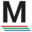
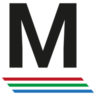
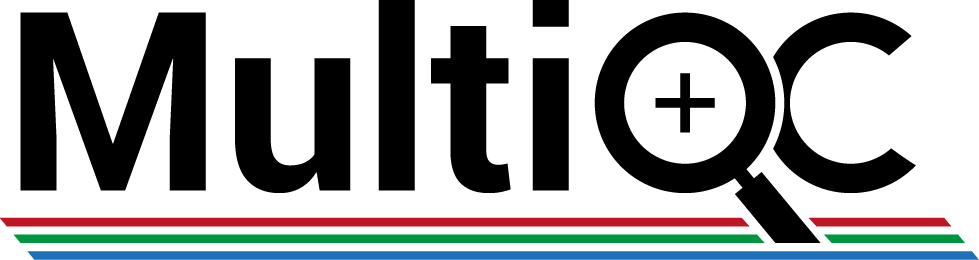
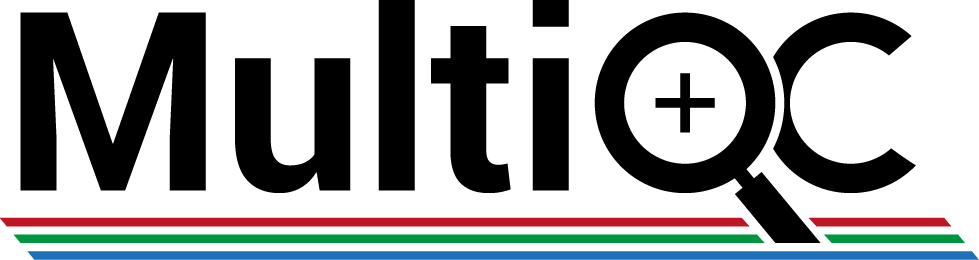
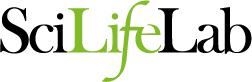

In [161]:
import IPython
IPython.display.HTML(filename='/Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/fastqc/raw-data/multiqc_report_rawdata.html')

## After trimming 

In [126]:
mkdir {workingdir}qc-processing/fastqc/cutadapt/

In [129]:
!{fastqc}fastqc \
{workingdir}qc-processing/cutadapt/*.fastq.trim \
--outdir {workingdir}qc-processing/fastqc/cutadapt/ \
--quiet

In [130]:
! multiqc {workingdir}qc-processing/fastqc/cutadapt/ --filename {workingdir}qc-processing/fastqc/cutadapt/multiqc_report_cutadapt.html

[INFO   ]         multiqc : This is MultiQC v1.9.dev0
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Searching   : /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/fastqc/cutadapt
[INFO   ]          fastqc : Found 8 reports
[INFO   ]         multiqc : Compressing plot data
[INFO   ]         multiqc : Report      : ../fastqc/cutadapt/multiqc_report_cutadapt.html
[INFO   ]         multiqc : Data        : ../fastqc/cutadapt/multiqc_report_cutadapt_data
[INFO   ]         multiqc : MultiQC complete



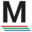
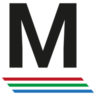
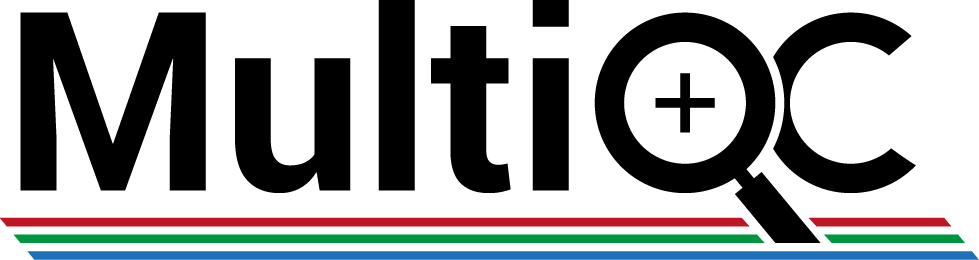
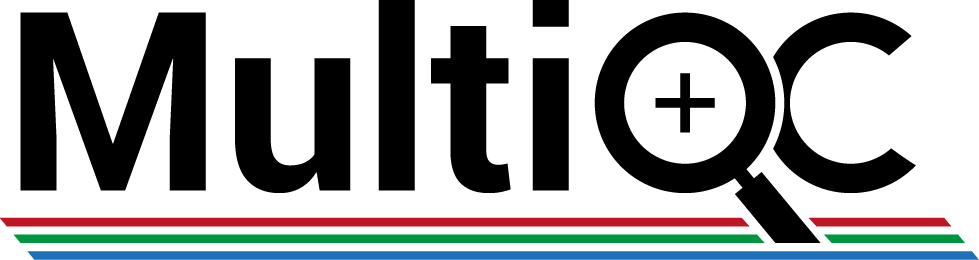
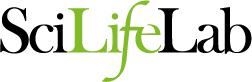

In [160]:
import IPython
IPython.display.HTML(filename='/Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/fastqc/cutadapt/multiqc_report_cutadapt.html')

### Count total no. reads before and after trimming 

In [131]:
# Before trimming
! wc -l {workingdir}raw-data/test-batch/*.fastq

 8148852 /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/141_S61_L001_R1_001.fastq
 36636468 /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/159_S68_L001_R1_001.fastq
 40847336 /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/302_S15_L001_R1_001.fastq
 27458608 /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/331_S53_L001_R1_001.fastq
 27711456 /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/34_S68_L002_R1_001.fastq
 36735912 /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/441_S73_L002_R1_001.fastq
 24512304 /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/483_S7_L002_R1_001.fastq
 33330752 /Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch/563_S59_L002_R1_001.fastq
 235381688 total


In [132]:
# After trimming
! wc -l {workingdir}qc-processing/cutadapt/*.trim

 7898348 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/141_S61_L001_R1_001.fastq.trim
 36101100 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/159_S68_L001_R1_001.fastq.trim
 39339968 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/302_S15_L001_R1_001.fastq.trim
 25964776 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/331_S53_L001_R1_001.fastq.trim
 26951488 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/34_S68_L002_R1_001.fastq.trim
 32289060 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/441_S73_L002_R1_001.fastq.trim
 22726468 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/483_S7_L002_R1_001.fastq.trim
 33000432 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/563_S59_L002_R1_001.fastq.trim
 224271640 total


## 95.28% reads remain after trimming and filtering 

(224,271,640/235,381,688*100)

### Hard trim first 12 bp 

The QuantSeq FAQ states the below, indicating that the first nucleotides may have high error rates. I will be testing the STAR aligner, but I also want to try using Bowtie2, with and without hard-trimming the first 12 bp of each read. 

_As second strand synthesis is based on random priming, **there may be a higher proportion of errors at the first nucleotides of the insert** due to non-specific hybridization of the random primer to the cDNA template. For QuantSeq FWD data **we therefore recommend using an aligner that can perform soft-clipping of the read ends (e.g., STAR aligner) during alignment**, or increasing the number of allowed mismatches to 14. **Alternatively, trimming the first 12 nt of Read 1 can be performed prior to alignment** when using a more stringent aligner (e.g., HISAT2). While trimming the read can decrease the number of reads of suitable length for alignment, the absolute number of mapping reads may increase due to the improved read quality._ 

I can do this using `cutadapt`. Since the `cutadapt` hard trimming option trims before adapter trimming, I'll re-run the whole trimming protocol on th raw data. Note: use `--cut N` to trim first N bases, and `--cut -N` to trim last N bases.

In [166]:
cd {workingdir}raw-data/test-batch/

/Volumes/Bumblebee/QuantSeq-04-21-2020/raw-data/test-batch


In [168]:
%%bash 

for F in *.fastq
do
#strip .fastq and directory structure from each file, then
# add ".hardtrim" to the suffice .fastq to create output name for each file with .fastq.hardtrim
results_file="$(basename -a $F).hardtrim"

/Users/laura/.local/bin/cutadapt $F --cut 12 -a A{8} -a G{8} -a AGATCGG -q 15 -m 20 -o \
../../qc-processing/cutadapt/$results_file
done

This is cutadapt 2.10 with Python 3.7.7
Command line parameters: 141_S61_L001_R1_001.fastq --cut 12 -a A{8} -a G{8} -a AGATCGG -q 15 -m 20 -o ../../qc-processing/cutadapt/141_S61_L001_R1_001.fastq.hardtrim
Processing reads on 1 core in single-end mode ...
Finished in 25.21 s (12 us/read; 4.85 M reads/minute).

=== Summary ===

Total reads processed:               2,037,213
Reads with adapters:                 1,147,991 (56.4%)
Reads written (passing filters):     1,939,986 (95.2%)

Total basepairs processed:   203,721,300 bp
Quality-trimmed:                 543,906 bp (0.3%)
Total written (filtered):    139,568,548 bp (68.5%)

=== Adapter 1 ===

Sequence: AAAAAAAA; Type: regular 3'; Length: 8; Trimmed: 1106988 times

No. of allowed errors:
0-8 bp: 0

Bases preceding removed adapters:
  A: 0.0%
  C: 29.5%
  G: 34.1%
  T: 36.3%
  none/other: 0.1%

Overview of removed sequences
length	count	expect	max.err	error counts
3	47060	31831.5	0	47060
4	29189	7957.9	0	29189
5	21969	1989.5	0	21969
6

In [169]:
! mkdir {workingdir}qc-processing/fastqc/cutadapt-hardtrim/

In [170]:
!{fastqc}fastqc \
{workingdir}qc-processing/cutadapt/*.fastq.hardtrim \
--outdir {workingdir}qc-processing/fastqc/cutadapt-hardtrim/ \
--quiet

In [171]:
! multiqc {workingdir}qc-processing/fastqc/cutadapt-hardtrim/ --filename {workingdir}qc-processing/fastqc/cutadapt-hardtrim/multiqc_report_cutadapt-hardtrim.html

[INFO   ]         multiqc : This is MultiQC v1.9.dev0
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Searching   : /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/fastqc/cutadapt-hardtrim
[INFO   ]          fastqc : Found 8 reports
[INFO   ]         multiqc : Compressing plot data
[INFO   ]         multiqc : Report      : ../../qc-processing/fastqc/cutadapt-hardtrim/multiqc_report_cutadapt-hardtrim.html
[INFO   ]         multiqc : Data        : ../../qc-processing/fastqc/cutadapt-hardtrim/multiqc_report_cutadapt-hardtrim_data
[INFO   ]         multiqc : MultiQC complete



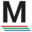
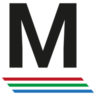
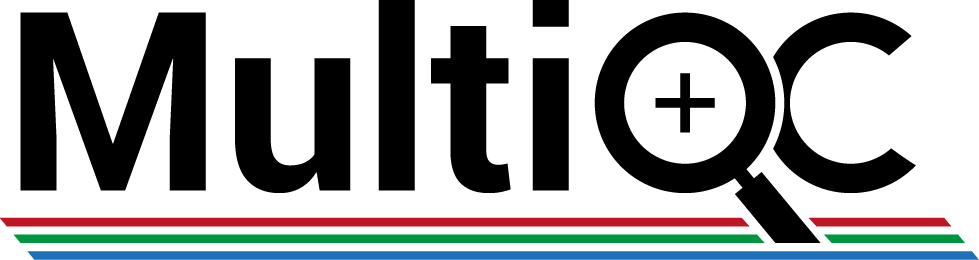
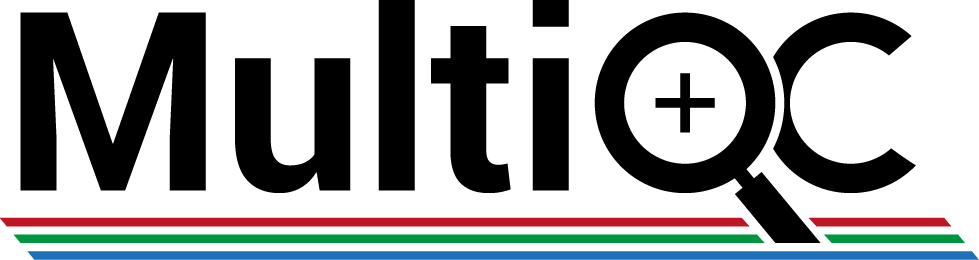
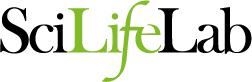

In [172]:
import IPython
IPython.display.HTML(filename='/Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/fastqc/cutadapt-hardtrim/multiqc_report_cutadapt-hardtrim.html')

### Count no. reads after trimming with first 12bp hard-trim

In [174]:
# After trimming
! wc -l {workingdir}qc-processing/cutadapt/*.hardtrim

 7759944 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/141_S61_L001_R1_001.fastq.hardtrim
 35585916 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/159_S68_L001_R1_001.fastq.hardtrim
 37455240 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/302_S15_L001_R1_001.fastq.hardtrim
 24665816 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/331_S53_L001_R1_001.fastq.hardtrim
 26126028 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/34_S68_L002_R1_001.fastq.hardtrim
 32147132 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/441_S73_L002_R1_001.fastq.hardtrim
 21191372 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/483_S7_L002_R1_001.fastq.hardtrim
 32513844 /Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/cutadapt/563_S59_L002_R1_001.fastq.hardtrim
 217445292 total


## 92.38% reads remain after trimming with hard-trimming and filtering 

(217,445,292/235,381,688*100)

## Align reads


The QuantSeq data analysis pipeline recommends using the [STAR aligner](https://github.com/alexdobin/STAR): 

**1.12 Which aligner should be used for data analysis?**
STAR aligner is recommended for mapping QuantSeq FWD (Cat.No. 015) data. The reads may not land in the last exon and span a junction. Reads should be trimmed prior to alignment to remove poly(A) tails and sequencing adapters (see FAQ. 1.13 below).

**1.13 What sequence should be trimmed?**
The reads should be trimmed to remove adapter sequences, poly(A) / poly(T) sequences, and low quality nucleotides. Reads that are too short (i.e., <20 nt) or have generally low quality scores should be removed from the set.

More about STAR in [Dobin et al. 2013](https://doi.org/10.1093/bioinformatics/bts635) & [Dobin et al. 2016](https://doi.org/10.1007/978-1-4939-3572-7_13)

I downloaded STAR using the following: 

    cd /Applications/bioinformatics/
    git clone https://github.com/alexdobin/STAR.git  # download STAR repo to my bioinf. app folder

I tried installing STAR following the directions on GitHub, using the following, but to no avail: 

    gcc --help #check to see if I have gcc installed on my computer. Yes, it is. 
    cd /Applications/bioinformatics/STAR/
    make STARforMacStatic CXX=/usr/local/Cellar/gcc/8.2.0/bin/g++-8 #build STAR. Note that the path to C++ executable had to be adjusted to its current version 
    
So, instead I will simply use the precompiled executable via the following path: 

    /Applications/bioinformatics/STAR/bin/MacOSX_x86_64/STAR 

In [175]:
# create path variable to STAR directory 
STAR = "/Applications/bioinformatics/STAR/bin/MacOSX_x86_64/STAR"

In [176]:
# confirm that path variable works 
! {STAR} --version

2.7.3a


### Download O. lurida genome 
(If needed)

In [88]:
! curl http://owl.fish.washington.edu/halfshell/genomic-databank/Olurida_v081.fa > {workingdir}/references/Olurida_v081.fa

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1090M  100 1090M    0     0  1960k      0  0:09:29  0:09:29 --:--:-- 2198k21k      0  0:08:46  0:00:17  0:08:29 2021k 0     0  2183k      0  0:08:31  0:01:11  0:07:20 2193k    0  2183k      0  0:08:31  0:01:14  0:07:17 2202k9  0:07:11 2212k1939k      0  0:09:35  0:01:45  0:07:50 1024k    0  1765k      0  0:10:32  0:02:00  0:08:32  497k   0     0  1752k      0  0:10:36  0:03:40  0:06:56 2190k    0  1748k      0  0:10:38  0:03:50  0:06:48 1105k  1855k      0  0:10:01  0:05:01  0:05:00 2215k  0     0  1861k      0  0:09:59  0:05:07  0:04:52 2191k   0  1881k      0  0:09:53  0:05:25  0:04:28 2222k931k      0  0:09:38  0:07:31  0:02:07 2169k  1929k      0  0:09:38  0:08:03  0:01:35 2179k 0  1933k      0  0:09:37  0:08:11  0:01:26 2200k  0  0:09:35  0:08:42  0:00:53 2212k


In [5]:
# MD5 should = 3ac56372bd62038f264d27eef0883bd3
! md5 {workingdir}references/Olurida_v081.fa

MD5 (/Volumes/Bumblebee/QuantSeq-04-21-2020/references/Olurida_v081.fa) = 3ac56372bd62038f264d27eef0883bd3


## Generate STAR genome index 

`{STAR} \`
`--runThreadN 8 \` _use 8 threads (I have quad core computer)_.  
`--runMode genomeGenerate \` _specify that I want to generate genome_.  
`--genomeDir {workingdir}STAR/ \` _specify path to save STAR genome directory. Must already exist_.   
`--genomeFastaFiles {workingdir}references/Olurida_v081.fa \` _specify path to genome_.  
`--sjdbGTFfile {workingdir}/references/Olurida_v081-20190709.exon.gff \` _specify path to annotations (.gtf files)_.   
`--sjdbGTFtagExonParentTranscript Parent \` _specify that my annotation file is GFF_.  
`--sjdbOverhang 99 \` _specify length of the genomic sequence around the annotated junction to be used in constructing the splice junctions database. Ideally, this length should be equal to the ReadLength-1, where ReadLength is the length of the reads. My reads are 100bp, so I'll use 99 (Default is 100)_.  
`--genomeChrBinNbits 12` _specify number of chromosome bins to use. See next few cells for this calculation_.  

#### Calculate # of genome chromosome bins 

This is to reduce RAM consumption, and b/c the _O. lurida_ genome has a ton of scaffolds/contigs. From the STAR manual:    

**2.2.6 Genome with a large number of references.** 
If you are using a genome with a large (>5,000) number of references (chro- somes/scaffolds), you may need to reduce the --genomeChrBinNbits to reduce RAM consumption. The following scaling is recommended: --genomeChrBinNbits =
 min(18,log2[max(GenomeLength/NumberOfReferences,ReadLength)]). 3 gigaBase genome with 100,000 chromosomes/scaffolds, this is equal to 15.

In [12]:
# Count the number of contigs in O. lurida genome, using the previously generated Bowtie index 
! wc -l {workingdir}references/Olurida_v081.fa.fai

  159429 /Volumes/Bumblebee/QuantSeq-04-21-2020/references/Olurida_v081.fa.fai


In [18]:
# Count total length of O. lurida genome. For some reason my workingdir path variable didn't work here 
!grep -v ">" /Volumes/Bumblebee/QuantSeq-04-21-2020/references/Olurida_v081.fa | wc | awk '{print $3-$1}'

1140787867


### calculate N for STAR --genomeChrBinNbits
Genome length = 1140787867 (1.1 billion bp)  
Number of References = 159429  
Read Length = 100bp  


N = min(18, log2[max(1140787867/318858, 100)])  
  = min(18, log2(max(3578, 100))  
  = min(18, log2(3578)   
  = min(18, 11.8)  
  = **12**  
  
### Identify annotation file .gtf format 

The STAR aligner uses an annotated transcript file alongside the genome to _"extract splice junctions ... and use thme to greatly improve accuracy of mapping"_. The annotation file format is .gtf.  There is an Oly exon feature file in GFF format. While the STAR manual indicates that .gff files can be used, according to multiple GitHub issues in the STAR repo (e.g. [issue #387](https://github.com/alexdobin/STAR/issues/387) and [issue #689](https://github.com/alexdobin/STAR/issues/689). There is an Oly annotation file in GTF format that includes exons and isoform information (alternative splice variants) - while I'm not 100% sure if this file contains _all_ exons (not just those with isoforms), I'm going to use this one at this time. Need to follow up to confirm that this file is okay to use. 

In [192]:
! head {workingdir}references/20190709-Olurida_v081.stringtie.gtf

# /gscratch/srlab/programs/stringtie-1.3.6.Linux_x86_64/stringtie --merge gtf_list.txt -p 27 -G /gscratch/srlab/sam/data/O_lurida/genomes/Olurida_v081/20190709-Olurida_v081_genome_snap02.all.renamed.putative_function.domain_added.gff -o 20190709-Olurida_v081.stringtie.gtf
# StringTie version 1.3.6
Contig0	StringTie	transcript	591	2392	1000	.	.	gene_id "MSTRG.1"; transcript_id "MSTRG.1.1"; 
Contig0	StringTie	exon	591	2392	1000	.	.	gene_id "MSTRG.1"; transcript_id "MSTRG.1.1"; exon_number "1"; 
Contig0	StringTie	transcript	12475	37133	1000	+	.	gene_id "MSTRG.2"; transcript_id "MSTRG.2.1"; 
Contig0	StringTie	exon	12475	12571	1000	+	.	gene_id "MSTRG.2"; transcript_id "MSTRG.2.1"; exon_number "1"; 
Contig0	StringTie	exon	13175	13233	1000	+	.	gene_id "MSTRG.2"; transcript_id "MSTRG.2.1"; exon_number "2"; 
Contig0	StringTie	exon	16209	16373	1000	+	.	gene_id "MSTRG.2"; transcript_id "MSTRG.2.1"; exon_number "3"; 
Contig0	StringTie	exon	17990	18153	1000	+	.	gene_id "MSTRG.2"; transcript_id "MST

## Build STAR genome index

In [195]:
! mkdir {workingdir}qc-processing/STAR/

In [196]:
cd {workingdir}qc-processing/STAR/

/Volumes/Bumblebee/QuantSeq-04-21-2020/qc-processing/STAR


In [ ]:
! {STAR} \
--runThreadN 8 \
--runMode genomeGenerate \
--genomeDir {workingdir}qc-processing/STAR/ \
--genomeFastaFiles {workingdir}references/Olurida_v081.fa \
--sjdbGTFfile {workingdir}references/20190709-Olurida_v081.stringtie.gtf \
--sjdbOverhang 99 \
--genomeChrBinNbits 12 \
done

May 07 21:27:35 ..... started STAR run
May 07 21:27:35 ... starting to generate Genome files


In [32]:
pwd

'/Users/laura/Documents/roberts-lab/laura-quantseq/notebooks'

In [55]:
cd {workingdir}STAR/

/Volumes/Bumblebee/QuantSeq-04-21-2020/STAR


#### Create a STAR output folder for each sample 

In [38]:
%%bash 

mkdir test-out
mkdir test-out/35_S72_L002
mkdir test-out/317_S33_L001
mkdir test-out/345_S16_L001
mkdir test-out/432_S75_L002

In [61]:
cd {workingdir}

/Volumes/Bumblebee/QuantSeq-04-21-2020


## Run STAR 

Use the trimmed reads that did _not_ include hard-trimming

`for sample in 35_S72_L002 317_S33_L001 345_S16_L001 432_S75_L002 ; do \`  
`{STAR} \`  
`--runThreadN 8 \`  _use 8 threads (my computer is quad-core)_  
`--genomeDir {workingdir}STAR/ \` _specify where genome directory was built_  
`--readFilesIn fastq/${sample}_R1_001.fastq.trim \` _specify where famples are_  
`--outFilterType BySJout \` _reduces the no, of spurious junctions_  
`--outFilterMultimapNmax 20 \` _max number of multiple alignments for a read; if exceeded, the read is considered unmapped_  
`--alignSJoverhangMin 8 \` _minimun overhang for unannotated junctions_  
`--alignSJDBoverhangMin 1 \` _minimum overhang for annotated junctions_  
`--outFilterMismatchNmax 999 \` _max no. of mixmatches per pair, large number switches off this filter_  
`--outFilterMismatchNoverLmax 0.1 \` _max no. of mismatches per pair relative to read length. for 2x100b, max number of mismatches is 0.04*200=8 for the paired read; my setting =0.1*100=10 for single read_   
`--alignIntronMin 20 \` _minimum intron length_  
`--alignIntronMax 1000000 \` _maximum intron length_  
`--alignMatesGapMax 1000000 \` _maximum genomic distance between mates_  
`--outSAMattributes NH HI NM MD \` _specify SAM attributes (see below)_
`--outSAMtype BAM SortedByCoordinate \` _output sorted by coordinate Aligned.sortedByCoord.out.bam file, similar to samtools sort command_.  
`--outFileNamePrefix star_out/${sample} ;\` 
`done`

SAM attributes:  
- NH HI NM MD : have standard meaning as defined in the SAM format specifications, see this [list of standard tags](https://samtools.github.io/hts-specs/SAMtags.pdf)  
- AS : id the local alignment score (paired for paired-end reads).  
- nM : is the number of mismatches per (paired) alignment, not to be confused with NM, which is the number of mismatches in each mate.  


**can I use `--quantMode GeneCounts` ??**

In [65]:
%%bash

for sample in 35_S72_L002 317_S33_L001 345_S16_L001 432_S75_L002 ; do \
/Applications/bioinformatics/STAR/bin/MacOSX_x86_64/STAR \
--runThreadN 8 \
--genomeDir STAR/ \
--readFilesIn STAR/test-data/${sample}_R1_001.fastq \
--readFilesType Fastx \
--outFilterType BySJout \
--outFilterMultimapNmax 20 \
--alignSJoverhangMin 8 \
--alignSJDBoverhangMin 1 \
--outFilterMismatchNmax 999 \
--outFilterMismatchNoverLmax 0.1 \
--alignIntronMin 20 \
--alignIntronMax 1000000 \
--alignMatesGapMax 1000000 \
--outSAMattributes NH HI NM MD AS nM \
--outSAMtype BAM SortedByCoordinate \
--outFileNamePrefix STAR/test-out/${sample} ;\
done

May 06 16:00:59 ..... started STAR run
May 06 16:00:59 ..... loading genome
May 06 16:02:02 ..... started mapping
May 06 16:05:13 ..... finished mapping
May 06 16:05:16 ..... started sorting BAM
May 06 16:05:19 ..... finished successfully
May 06 16:05:20 ..... started STAR run
May 06 16:05:20 ..... loading genome
May 06 16:06:14 ..... started mapping
May 06 16:48:34 ..... finished mapping
May 06 16:48:37 ..... started sorting BAM
May 06 16:48:44 ..... finished successfully
May 06 16:48:44 ..... started STAR run
May 06 16:48:44 ..... loading genome
May 06 16:49:25 ..... started mapping
May 06 17:19:34 ..... finished mapping
May 06 17:19:37 ..... started sorting BAM
May 06 17:19:44 ..... finished successfully
May 06 17:19:44 ..... started STAR run
May 06 17:19:44 ..... loading genome
May 06 17:20:25 ..... started mapping


bash: line 2:  3101 Killed: 9               /Applications/bioinformatics/STAR/bin/MacOSX_x86_64/STAR --runThreadN 8 --genomeDir STAR/ --readFilesIn STAR/test-data/${sample}_R1_001.fastq --readFilesType Fastx --outFilterType BySJout --outFilterMultimapNmax 20 --alignSJoverhangMin 8 --alignSJDBoverhangMin 1 --outFilterMismatchNmax 999 --outFilterMismatchNoverLmax 0.1 --alignIntronMin 20 --alignIntronMax 1000000 --alignMatesGapMax 1000000 --outSAMattributes NH HI NM MD AS nM --outSAMtype BAM SortedByCoordinate --outFileNamePrefix STAR/test-out/${sample}


CalledProcessError: Command 'b'\nfor sample in 35_S72_L002 317_S33_L001 345_S16_L001 432_S75_L002 ; do \\\n/Applications/bioinformatics/STAR/bin/MacOSX_x86_64/STAR \\\n--runThreadN 8 \\\n--genomeDir STAR/ \\\n--readFilesIn STAR/test-data/${sample}_R1_001.fastq \\\n--readFilesType Fastx \\\n--outFilterType BySJout \\\n--outFilterMultimapNmax 20 \\\n--alignSJoverhangMin 8 \\\n--alignSJDBoverhangMin 1 \\\n--outFilterMismatchNmax 999 \\\n--outFilterMismatchNoverLmax 0.1 \\\n--alignIntronMin 20 \\\n--alignIntronMax 1000000 \\\n--alignMatesGapMax 1000000 \\\n--outSAMattributes NH HI NM MD AS nM \\\n--outSAMtype BAM SortedByCoordinate \\\n--outFileNamePrefix STAR/test-out/${sample} ;\\\ndone\n'' returned non-zero exit status 137.

#### for some reason sample 432 didn't finish. Try that one again by itself, see if it works this time. 

In [66]:
%%bash

/Applications/bioinformatics/STAR/bin/MacOSX_x86_64/STAR \
--runThreadN 8 \
--genomeDir STAR/ \
--readFilesIn STAR/test-data/432_S75_L002_R1_001.fastq \
--readFilesType Fastx \
--outFilterType BySJout \
--outFilterMultimapNmax 20 \
--alignSJoverhangMin 8 \
--alignSJDBoverhangMin 1 \
--outFilterMismatchNmax 999 \
--outFilterMismatchNoverLmax 0.1 \
--alignIntronMin 20 \
--alignIntronMax 1000000 \
--alignMatesGapMax 1000000 \
--outSAMattributes NH HI NM MD AS nM \
--outSAMtype BAM SortedByCoordinate \
--outFileNamePrefix STAR/test-out/432_S75_L002

May 06 18:12:22 ..... started STAR run
May 06 18:12:22 ..... loading genome
May 06 18:13:17 ..... started mapping


bash: line 18:  3394 Killed: 9               /Applications/bioinformatics/STAR/bin/MacOSX_x86_64/STAR --runThreadN 8 --genomeDir STAR/ --readFilesIn STAR/test-data/432_S75_L002_R1_001.fastq --readFilesType Fastx --outFilterType BySJout --outFilterMultimapNmax 20 --alignSJoverhangMin 8 --alignSJDBoverhangMin 1 --outFilterMismatchNmax 999 --outFilterMismatchNoverLmax 0.1 --alignIntronMin 20 --alignIntronMax 1000000 --alignMatesGapMax 1000000 --outSAMattributes NH HI NM MD AS nM --outSAMtype BAM SortedByCoordinate --outFileNamePrefix STAR/test-out/432_S75_L002


CalledProcessError: Command 'b'\n/Applications/bioinformatics/STAR/bin/MacOSX_x86_64/STAR \\\n--runThreadN 8 \\\n--genomeDir STAR/ \\\n--readFilesIn STAR/test-data/432_S75_L002_R1_001.fastq \\\n--readFilesType Fastx \\\n--outFilterType BySJout \\\n--outFilterMultimapNmax 20 \\\n--alignSJoverhangMin 8 \\\n--alignSJDBoverhangMin 1 \\\n--outFilterMismatchNmax 999 \\\n--outFilterMismatchNoverLmax 0.1 \\\n--alignIntronMin 20 \\\n--alignIntronMax 1000000 \\\n--alignMatesGapMax 1000000 \\\n--outSAMattributes NH HI NM MD AS nM \\\n--outSAMtype BAM SortedByCoordinate \\\n--outFileNamePrefix STAR/test-out/432_S75_L002\n'' returned non-zero exit status 137.

#### Sample 432 has very low % of unique reads. Maybe that's why? Try another sample that has lots of duplicated reads, sample 412

In [67]:
%%bash

/Applications/bioinformatics/STAR/bin/MacOSX_x86_64/STAR \
--runThreadN 8 \
--genomeDir STAR/ \
--readFilesIn STAR/test-data/412_S74_L002_R1_001.fastq.trim \
--readFilesType Fastx \
--outFilterType BySJout \
--outFilterMultimapNmax 20 \
--alignSJoverhangMin 8 \
--alignSJDBoverhangMin 1 \
--outFilterMismatchNmax 999 \
--outFilterMismatchNoverLmax 0.1 \
--alignIntronMin 20 \
--alignIntronMax 1000000 \
--alignMatesGapMax 1000000 \
--outSAMattributes NH HI NM MD AS nM \
--outSAMtype BAM SortedByCoordinate \
--outFileNamePrefix STAR/test-out/412

May 06 18:22:03 ..... started STAR run
May 06 18:22:03 ..... loading genome
May 06 18:22:48 ..... started mapping
May 06 18:28:20 ..... finished mapping
May 06 18:28:22 ..... started sorting BAM
May 06 18:28:25 ..... finished successfully


                                 UNMAPPED READS:
Number of reads unmapped: too many mismatches |	651  
% of reads unmapped: too many mismatches |	0.01%  
Number of reads unmapped: too short |	5209111  
% of reads unmapped: too short |	78.20%  
Number of reads unmapped: other |	5521  
% of reads unmapped: other |	0.08%  

#### Try re-running on this sample with the following additional options, which relax the requirements on the mapped/aligned length: 

    --outFilterScoreMinOverLread 0.3 
    --outFilterMatchNminOverLread 0.3

In [68]:
%%bash

/Applications/bioinformatics/STAR/bin/MacOSX_x86_64/STAR \
--runThreadN 8 \
--genomeDir STAR/ \
--readFilesIn STAR/test-data/412_S74_L002_R1_001.fastq.trim \
--readFilesType Fastx \
--outFilterType BySJout \
--outFilterMultimapNmax 20 \
--alignSJoverhangMin 8 \
--alignSJDBoverhangMin 1 \
--outFilterMismatchNmax 999 \
--outFilterMismatchNoverLmax 0.1 \
--outFilterScoreMinOverLread 0.3 \
--outFilterMatchNminOverLread 0.3 \
--alignIntronMin 20 \
--alignIntronMax 1000000 \
--alignMatesGapMax 1000000 \
--outSAMattributes NH HI NM MD AS nM \
--outSAMtype BAM SortedByCoordinate \
--outFileNamePrefix STAR/test-out/412

May 06 18:57:56 ..... started STAR run
May 06 18:57:56 ..... loading genome
May 06 18:58:41 ..... started mapping
May 06 19:04:37 ..... finished mapping
May 06 19:04:39 ..... started sorting BAM
May 06 19:04:47 ..... finished successfully


UNMAPPED READS:  
Number of reads unmapped: too many mismatches |	29257  
% of reads unmapped: too many mismatches |	0.44%  
Number of reads unmapped: too short |	3334705  
% of reads unmapped: too short |	50.06%  
Number of reads unmapped: other |	5521  
% of reads unmapped: other |	0.08%  


The unmapped too-short % has reduced from 78% to 50%. That's better. 

Try adding this option to output all unmapped reads into a fastq/fastq file: 

`--outReadsUnmapped Fastx`

#### Indexed bam files are necessary for many visualization and downstream analysis tools

In [71]:
%%bash 

cd STAR/test-out
for bamfile in *Aligned.sortedByCoord.out.bam ; do samtools index ${bamfile}; done

samtools index: "432_S75_L002Aligned.sortedByCoord.out.bam" is in a format that cannot be usefully indexed


CalledProcessError: Command 'b'\ncd STAR/test-out\nfor bamfile in *Aligned.sortedByCoord.out.bam ; do samtools index ${bamfile}; done\n'' returned non-zero exit status 1.

In [72]:
pwd

'/Volumes/Bumblebee/QuantSeq-04-21-2020'

### Try using bowtie to align reads 

In [30]:
! mkdir {workingdir}bowtie/

In [73]:
cd bowtie/

/Volumes/Bumblebee/QuantSeq-04-21-2020/bowtie


In [37]:
%%bash
### creating bowtie2 index for Oly genome v081:

bowtie2-build \
../../references/Olurida_v081.fa \
Olurida_v081.fa

Settings:
  Output files: "Olurida_v081.fa.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  ../../references/Olurida_v081.fa
Reading reference sizes
  Time reading reference sizes: 00:00:12
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:07
bmax according to bmaxDivN setting: 269313774
Using parameters --bmax 201985331 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 201985331 --dcv 1024
Constructing suffix-

Building a SMALL index


In [75]:
ls

Olurida_v081.fa.1.bt2*     Olurida_v081.fa.rev.1.bt2*
Olurida_v081.fa.2.bt2*     Olurida_v081.fa.rev.2.bt2*
Olurida_v081.fa.3.bt2*     test-data/
Olurida_v081.fa.4.bt2*


In [77]:
cd test-data/ 

[Errno 2] No such file or directory: 'test-data/ | ls'
/Volumes/Bumblebee/QuantSeq-04-21-2020/bowtie/test-data


In [79]:
ls

317_S33_L001_R1_001.fastq.trim* 412_S74_L002_R1_001.fastq.trim*
345_S16_L001_R1_001.fastq.trim* 432_S75_L002_R1_001.fastq.trim*
35_S72_L002_R1_001.fastq.trim*


In [87]:
! {tagseq}tagseq_bowtie2map.pl "trim$" {workingdir}bowtie/Olurida_v081.fa > maps

In [89]:
! head maps

bowtie2 --local -x /Volumes/Bumblebee/QuantSeq-04-21-2020/bowtie/Olurida_v081.fa -U 317_S33_L001_R1_001.fastq.trim -S 317_S33_L001_R1_001.fastq.trim.sam --no-hd --no-sq --no-unal -k 5
bowtie2 --local -x /Volumes/Bumblebee/QuantSeq-04-21-2020/bowtie/Olurida_v081.fa -U 412_S74_L002_R1_001.fastq.trim -S 412_S74_L002_R1_001.fastq.trim.sam --no-hd --no-sq --no-unal -k 5
bowtie2 --local -x /Volumes/Bumblebee/QuantSeq-04-21-2020/bowtie/Olurida_v081.fa -U 35_S72_L002_R1_001.fastq.trim -S 35_S72_L002_R1_001.fastq.trim.sam --no-hd --no-sq --no-unal -k 5
bowtie2 --local -x /Volumes/Bumblebee/QuantSeq-04-21-2020/bowtie/Olurida_v081.fa -U 345_S16_L001_R1_001.fastq.trim -S 345_S16_L001_R1_001.fastq.trim.sam --no-hd --no-sq --no-unal -k 5
bowtie2 --local -x /Volumes/Bumblebee/QuantSeq-04-21-2020/bowtie/Olurida_v081.fa -U 432_S75_L002_R1_001.fastq.trim -S 432_S75_L002_R1_001.fastq.trim.sam --no-hd --no-sq --no-unal -k 5


In [95]:
# make sure bowtie2 is in path and working
! bowtie2 --version

/usr/local/bin/../Cellar/bowtie2/2.3.4.3/bin/bowtie2-align-s version 2.3.4.3
64-bit
Built on HighSierra-2.local
Tue Nov  6 03:21:56 GMT 2018
Compiler: InstalledDir: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin
Options: -O3 -m64 -msse2 -funroll-loops -g3 -std=c++98 -DPOPCNT_CAPABILITY -DWITH_TBB -DNO_SPINLOCK -DWITH_QUEUELOCK=1
Sizeof {int, long, long long, void*, size_t, off_t}: {4, 8, 8, 8, 8, 8}


### Use a loop to execute the commands written in 'maps'; redirect screen output/error in bowtieout.txt

--no-unal  = suppress SAM records for unaligned reads  
--no-sq    = suppress @SQ header lines  
--no-hd    = suppress SAM header lines (starting with @)  
-k 5       = report up to <5> aligns per read  

In [96]:
pwd

'/Volumes/Bumblebee/QuantSeq-04-21-2020/bowtie/test-data'

In [97]:
%%bash 

for file in *.trim
do
#strip .fastq and directorys tructure from each file, then
# add suffice .fastq.trim to create output name for each file
results_file="$(basename -a $file).sam"

# run tagseq scripts on each file
bowtie2 --local -x \
../Olurida_v081.fa \
-U $file \
-S $results_file \ -k 5; \
done >> ../bowtieout.txt 2>&1

In [99]:
! cat ../bowtieout.txt

5632616 reads; of these:
  5632616 (100.00%) were unpaired; of these:
    1111357 (19.73%) aligned 0 times
    2577493 (45.76%) aligned exactly 1 time
    1943766 (34.51%) aligned >1 times
80.27% overall alignment rate
5459486 reads; of these:
  5459486 (100.00%) were unpaired; of these:
    1204735 (22.07%) aligned 0 times
    2681422 (49.11%) aligned exactly 1 time
    1573329 (28.82%) aligned >1 times
77.93% overall alignment rate
1967890 reads; of these:
  1967890 (100.00%) were unpaired; of these:
    491245 (24.96%) aligned 0 times
    445919 (22.66%) aligned exactly 1 time
    1030726 (52.38%) aligned >1 times
75.04% overall alignment rate
6661477 reads; of these:
  6661477 (100.00%) were unpaired; of these:
    4224328 (63.41%) aligned 0 times
    934424 (14.03%) aligned exactly 1 time
    1502725 (22.56%) aligned >1 times
36.59% overall alignment rate
5886611 reads; of these:
  5886611 (100.00%) were unpaired; of these:
    1031715 (17.53%) aligned 0 times
    1145836 (19.47%)

In [100]:
# alignment rates:
! grep "overall alignment rate" ../bowtieout.txt

80.27% overall alignment rate
77.93% overall alignment rate
75.04% overall alignment rate
36.59% overall alignment rate
82.47% overall alignment rate


In [112]:
# alignment rates:
! grep "overall alignment rate"  ../../results/bowtie/bowtieout.txt

70.86% overall alignment rate
71.38% overall alignment rate
21.97% overall alignment rate
71.42% overall alignment rate
74.25% overall alignment rate
74.05% overall alignment rate
69.84% overall alignment rate
71.05% overall alignment rate
69.79% overall alignment rate
65.44% overall alignment rate
73.34% overall alignment rate
41.75% overall alignment rate
73.35% overall alignment rate
73.44% overall alignment rate
63.80% overall alignment rate
73.59% overall alignment rate
57.34% overall alignment rate
71.77% overall alignment rate
74.38% overall alignment rate
74.85% overall alignment rate
62.80% overall alignment rate
68.49% overall alignment rate
73.56% overall alignment rate
71.53% overall alignment rate


## Generating read-counts-per gene 

In [113]:
ls

CP-KS-LibL-L10-G_S59_L006_R1_001.fastq.trim
CP-KS-LibL-L10-G_S59_L006_R1_001.fastq.trim.sam
CP-KS-LibL-L11-G_S65_L006_R1_001.fastq.trim
CP-KS-LibL-L11-G_S65_L006_R1_001.fastq.trim.sam
CP-KS-LibL-L13-G_S60_L006_R1_001.fastq.trim
CP-KS-LibL-L13-G_S60_L006_R1_001.fastq.trim.sam
CP-KS-LibL-L14-G_S63_L006_R1_001.fastq.trim
CP-KS-LibL-L14-G_S63_L006_R1_001.fastq.trim.sam
CP-KS-LibL-L15-G_S68_L006_R1_001.fastq.trim
CP-KS-LibL-L15-G_S68_L006_R1_001.fastq.trim.sam
CP-KS-LibL-L19-G_S67_L006_R1_001.fastq.trim
CP-KS-LibL-L19-G_S67_L006_R1_001.fastq.trim.sam
CP-KS-LibL-L2-G_S34_L006_R1_001.fastq.trim
CP-KS-LibL-L2-G_S34_L006_R1_001.fastq.trim.sam
CP-KS-LibL-L21-G_S58_L006_R1_001.fastq.trim
CP-KS-LibL-L21-G_S58_L006_R1_001.fastq.trim.sam
CP-KS-LibL-L23-G_S61_L006_R1_001.fastq.trim
CP-KS-LibL-L23-G_S61_L006_R1_001.fastq.trim.sam
CP-KS-LibL-L24-G_S62_L006_R1_001.fastq.trim
CP-KS-LibL-L24-G_S62_L006_R1_001.fastq.trim.sam
CP-KS-LibL-L29-G_S36_L006_R1_001.fastq.trim
CP-KS-LibL-L29-G_S36_L006_R1_001.fastq

In [82]:
! grep ">" ../../references/Olurida_v081.fa | head

>Contig0
>Contig1
>Contig2
>Contig3
>Contig4
>Contig5
>Contig6
>Contig7
>Contig8
>Contig9


In [63]:
! samtools view --help

samtools view: unrecognised option '--help'

Usage: samtools view [options] <in.bam>|<in.sam>|<in.cram> [region ...]

Options:
  -b       output BAM
  -C       output CRAM (requires -T)
  -1       use fast BAM compression (implies -b)
  -u       uncompressed BAM output (implies -b)
  -h       include header in SAM output
  -H       print SAM header only (no alignments)
  -c       print only the count of matching records
  -o FILE  output file name [stdout]
  -U FILE  output reads not selected by filters to FILE [null]
  -t FILE  FILE listing reference names and lengths (see long help) [null]
  -L FILE  only include reads overlapping this BED FILE [null]
  -r STR   only include reads in read group STR [null]
  -R FILE  only include reads with read group listed in FILE [null]
  -q INT   only include reads with mapping quality >= INT [0]
  -l STR   only include reads in library STR [null]
  -m INT   only include reads with number of CIGAR operations consuming
           query sequence >= 

In [114]:
%%bash
#convert sam to bam

for file in *.sam
do
results_file="$(basename -a $file)_sorted.bam"
samtools view -b $file | samtools sort -o $results_file
done

In [115]:
%%bash
# create .bam indexes
for file in *.bam
do
samtools index $file
done

In [118]:
ls *.bam

CP-KS-LibL-L10-G_S59_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L11-G_S65_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L13-G_S60_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L14-G_S63_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L15-G_S68_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L19-G_S67_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L2-G_S34_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L21-G_S58_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L23-G_S61_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L24-G_S62_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L29-G_S36_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L3-G_S64_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L32-G_S35_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L33-G_S66_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L34-L_S25_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L35-L_S31_L006_R1_001.fastq.trim.sam_sorted.bam
CP-KS-LibL-L37-L_S32_L006_R1_001.fastq.trim.sam_sorted.bam

In [121]:
# total mapped and paired reads 
! samtools view -F 6 \
CP-KS-LibL-L7-G_S57_L006_R1_001.fastq.trim.sam_sorted.bam | \
wc -l

   27324


In [122]:
# weird, this is supposed to be the unmapped read count .. same as above
! samtools view -F 4 \
CP-KS-LibL-L7-G_S57_L006_R1_001.fastq.trim.sam_sorted.bam | \
wc -l

   27324


# BONEYARD

In [31]:
# run perl script that creates list of executables for each fastq file 
! {tagseq}tagseq_trim_launch.pl '\.fastq$' > clean

In [106]:
! head -2 clean

head: clean: No such file or directory


### Based on repeated functions in the clean file, I wrote a script to loop through the files and execute all commands 

- `tagseq_clipper.pl` clips 5'-leader off Illumina fastq reads in RNA-seq  
- `fastx_clipper` is part of the [fastx_toolkit](http://hannonlab.cshl.edu/fastx_toolkit/commandline.html#fastx_clipper_usage), and removes sequencing adapters / linkers. Options include: 
  - `-a AAAAAAAA` _remove the adapter string AAAAAAAA_  
  - `-a AGATCGGAAG` _remove the adapter string AGATCGGAAG_  
  - `-l 20` _discard sequences shorter than 20bp_  
- `fastq_quality_filter` filters out reads based on their quality score. 
  - `-q 20` _minimum quality score to keep_  
  - `p 90` _minimum perxentage of bases that must have the minimum quality_  
- `-Q33` _I don't know what this_ 

### Run clean script on all .fastq files in the Batch2 folder 

Based on repeated functions in the clean file, I wrote a script to loop through the files and execute all commands. Also, for some reason I cannot access my {tagseq} variable to call the tagseq script, so I just hard-code the path. 

In [65]:
%%bash 

for file in *.fastq
do
#strip .fastq and directory structure from each file, then
# add suffice .fastq.trim to create output name for each file
results_file="$(basename -a $file).trim"

# run tagseq scripts on each file
/Applications/bioinformatics/tag-based_RNAseq/tagseq_clipper.pl $file | \
fastx_clipper -a AAAAAAAA -l 20 -Q33 | \
fastx_clipper -a AGATCGGAAG -l 20 -Q33 | \
fastq_quality_filter -Q33 -q 20 -p 90 >\
../tagseq_trim/$results_file
done

34_S68_L002_R1_001.fastq	total:6927864	goods:15028	dups:43430	noheader:6869376	N.in.header:30
35_S72_L002_R1_001.fastq	total:2727730	goods:3747	dups:15243	noheader:2708735	N.in.header:5
37_S70_L002_R1_001.fastq	total:7605760	goods:10723	dups:49986	noheader:7545035	N.in.header:16
39_S52_L002_R1_001.fastq	total:5993536	goods:34743	dups:29301	noheader:5929468	N.in.header:24
401_S10_L002_R1_001.fastq	total:4142817	goods:16582	dups:39511	noheader:4086706	N.in.header:18
402_S5_L002_R1_001.fastq	total:5817900	goods:35240	dups:31075	noheader:5751561	N.in.header:24
403_S30_L002_R1_001.fastq	total:6761607	goods:44917	dups:32983	noheader:6683688	N.in.header:19
404_S42_L002_R1_001.fastq	total:7000213	goods:36860	dups:65429	noheader:6897891	N.in.header:33
411_S9_L002_R1_001.fastq	total:6647774	goods:36443	dups:36710	noheader:6574594	N.in.header:27
412_S74_L002_R1_001.fastq	total:7052231	goods:2643	dups:45313	noheader:7004263	N.in.header:12
413_S38_L002_R1_001.fastq	total:6420294	goods:29188	dups:31

In [85]:
cd ../Batch1_69plex_lane1_done/

/Volumes/Peach Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done


In [86]:
ls

137_S63_L001_R1_001.fastq          314_S49_L001_R1_001.fastq
139_S54_L001_R1_001.fastq          315_S26_L001_R1_001.fastq
140_S64_L001_R1_001.fastq          316_S9_L001_R1_001.fastq
141_S61_L001_R1_001.fastq          317_S33_L001_R1_001.fastq
156_S66_L001_R1_001.fastq          318_S6_L001_R1_001.fastq
159_S68_L001_R1_001.fastq          319_S52_L001_R1_001.fastq
161_S57_L001_R1_001.fastq          321_S29_L001_R1_001.fastq
162_S62_L001_R1_001.fastq          322_S8_L001_R1_001.fastq
168_S67_L001_R1_001.fastq          323_S39_L001_R1_001.fastq
169_S65_L001_R1_001.fastq          324_S47_L001_R1_001.fastq
171_S58_L001_R1_001.fastq          325_S13_L001_R1_001.fastq
172_S59_L001_R1_001.fastq          326_S38_L001_R1_001.fastq
181_S69_L001_R1_001.fastq          327_S37_L001_R1_001.fastq
183_S56_L001_R1_001.fastq          328_S12_L001_R1_001.fastq
184_S55_L001_R1_001.fastq          329_S46_L001_R1_001.fastq
185_S60_L001_R1_001.fastq          331_S53_L001_R1_001.fastq
291_S42_L001_R1_001.fastq  

In [87]:
%%bash 

for file in *.fastq
do
#strip .fastq and directory structure from each file, then
# add suffice .fastq.trim to create output name for each file
results_file="$(basename -a $file).trim"

# run tagseq scripts on each file
/Applications/bioinformatics/tag-based_RNAseq/tagseq_clipper.pl $file | \
fastx_clipper -a AAAAAAAA -l 20 -Q33 | \
fastx_clipper -a AGATCGGAAG -l 20 -Q33 | \
fastq_quality_filter -Q33 -q 20 -p 90 >\
../tagseq_trim/$results_file
done

137_S63_L001_R1_001.fastq	total:6404696	goods:41515	dups:41541	noheader:6321593	N.in.header:47
139_S54_L001_R1_001.fastq	total:2349211	goods:17843	dups:10878	noheader:2320472	N.in.header:18
140_S64_L001_R1_001.fastq	total:5892333	goods:36814	dups:39211	noheader:5816270	N.in.header:38
141_S61_L001_R1_001.fastq	total:2037213	goods:16246	dups:11910	noheader:2009041	N.in.header:16
156_S66_L001_R1_001.fastq	total:5179056	goods:25706	dups:39219	noheader:5114080	N.in.header:51
159_S68_L001_R1_001.fastq	total:9159117	goods:41332	dups:66642	noheader:9051086	N.in.header:57
161_S57_L001_R1_001.fastq	total:6891720	goods:39203	dups:33358	noheader:6819119	N.in.header:40
162_S62_L001_R1_001.fastq	total:6282792	goods:35921	dups:38640	noheader:6208201	N.in.header:30
168_S67_L001_R1_001.fastq	total:3059208	goods:20207	dups:21910	noheader:3017063	N.in.header:28
169_S65_L001_R1_001.fastq	total:11072381	goods:60414	dups:83124	noheader:10928753	N.in.header:90
171_S58_L001_R1_001.fastq	total:8290001	goods:45

### The following script is from the tag_seq processing readme, and it creates a .txt file with individual lines that execute the cleaning process for each file

In [134]:
%%bash 

# Create cleaning process commands for all files:
>clean
for F in *.fastq; do
echo "tagseq_clipper.pl $F | /Users/laura/.local/bin/cutadapt - -a AAAAAAAA -a AGATCGG -q 15 -m 25 -o ${F/.fq/}.trim" >>clean;
done

In [59]:
# create a directory to store trim data 
! mkdir ../tagseq_trim/

### Run clean script on all .fastq files 

Based on repeated functions in the above clean file, I wrote a script to loop through the files and execute all commands. Also, for some reason I cannot access my {tagseq} variable to call the tagseq script (or cutadapt program), so I just hard-code the path. 

### Here's what the clean script does:

`tagseq_clipper.pl`: 

`cutadapt`: 
  - `-a AAAAAAAA`: specify adapter 1 (Poly-a); `-a` indicates it is a Regular 3' adapter  
  - `-a AGATCGG`: specify adapter 2 (Illumina Universal Adapter); `-a` indicates it is a Regular 3' adapter  
  - `q 15` = trim low-quality ends from reads. Since I specify a single cutoff value, the 3’ end of each read is trimmed.  
  - `-m 25` Discard processed reads that are shorter than 25 bp   
  - `-o ../tagseq_trim/$results_file`: specify the output file for all trimmed & filtered reads 


### First clean up fastq files in the Batch1 directory 

In [147]:
cd ../Batch1_69plex_lane1_done/

/Volumes/Peach Backup/QuantSeq-04-21-2020/Batch1_69plex_lane1_done


In [135]:
%%bash 

for F in *.fastq
do
#strip .fastq and directory structure from each file, then
# add suffice .fastq.trim to create output name for each file
results_file="$(basename -a $F).trim"

# run tagseq scripts on each file
/Applications/bioinformatics/tag-based_RNAseq/tagseq_clipper.pl $F | \
/Users/laura/.local/bin/cutadapt - -a AAAAAAAA -a AGATCGG -q 15 -m 25 -o \
../tagseq_trim/$results_file
done

This is cutadapt 2.10 with Python 3.7.7
Command line parameters: - -a AAAAAAAA -a AGATCGG -q 15 -m 25 -o ../tagseq_trim/137_S63_L001_R1_001.fastq.trim
Processing reads on 1 core in single-end mode ...
Finished in 23.14 s (557 us/read; 0.11 M reads/minute).

=== Summary ===

Total reads processed:                  41,515
Reads with adapters:                    20,768 (50.0%)
Reads written (passing filters):        39,980 (96.3%)

Total basepairs processed:     3,853,127 bp
Quality-trimmed:                   7,605 bp (0.2%)
Total written (filtered):      3,153,173 bp (81.8%)

=== Adapter 1 ===

Sequence: AAAAAAAA; Type: regular 3'; Length: 8; Trimmed: 20046 times

No. of allowed errors:
0-8 bp: 0

Bases preceding removed adapters:
  A: 0.0%
  C: 34.0%
  G: 34.5%
  T: 30.9%
  none/other: 0.6%

Overview of removed sequences
length	count	expect	max.err	error counts
3	1004	648.7	0	1004
4	533	162.2	0	533
5	369	40.5	0	369
6	399	10.1	0	399
7	331	2.5	0	331
8	369	0.6	0	369
9	340	0.6	0	340
10	273	

137_S63_L001_R1_001.fastq	total:6404696	goods:41515	dups:41541	noheader:6321593	N.in.header:47
139_S54_L001_R1_001.fastq	total:2349211	goods:17843	dups:10878	noheader:2320472	N.in.header:18
140_S64_L001_R1_001.fastq	total:5892333	goods:36814	dups:39211	noheader:5816270	N.in.header:38
141_S61_L001_R1_001.fastq	total:2037213	goods:16246	dups:11910	noheader:2009041	N.in.header:16
156_S66_L001_R1_001.fastq	total:5179056	goods:25706	dups:39219	noheader:5114080	N.in.header:51
159_S68_L001_R1_001.fastq	total:9159117	goods:41332	dups:66642	noheader:9051086	N.in.header:57
161_S57_L001_R1_001.fastq	total:6891720	goods:39203	dups:33358	noheader:6819119	N.in.header:40
162_S62_L001_R1_001.fastq	total:6282792	goods:35921	dups:38640	noheader:6208201	N.in.header:30
168_S67_L001_R1_001.fastq	total:3059208	goods:20207	dups:21910	noheader:3017063	N.in.header:28
169_S65_L001_R1_001.fastq	total:11072381	goods:60414	dups:83124	noheader:10928753	N.in.header:90
171_S58_L001_R1_001.fastq	total:8290001	goods:45

### Move to Batch2 directory, run same script on those fastq files 

In [136]:
cd ../Batch2_77plex_lane2_done/

/Volumes/Peach Backup/QuantSeq-04-21-2020/Batch2_77plex_lane2_done


In [137]:
%%bash 

for F in *.fastq
do
#strip .fastq and directory structure from each file, then
# add suffice .fastq.trim to create output name for each file
results_file="$(basename -a $F).trim"

# run tagseq scripts on each file
/Applications/bioinformatics/tag-based_RNAseq/tagseq_clipper.pl $F | \
/Users/laura/.local/bin/cutadapt - -a AAAAAAAA -a AGATCGG -q 15 -m 25 -o \
../tagseq_trim/$results_file
done

This is cutadapt 2.10 with Python 3.7.7
Command line parameters: - -a AAAAAAAA -a AGATCGG -q 15 -m 25 -o ../tagseq_trim/34_S68_L002_R1_001.fastq.trim
Processing reads on 1 core in single-end mode ...
Finished in 26.26 s (1747 us/read; 0.03 M reads/minute).

=== Summary ===

Total reads processed:                  15,028
Reads with adapters:                     9,303 (61.9%)
Reads written (passing filters):        13,587 (90.4%)

Total basepairs processed:     1,394,051 bp
Quality-trimmed:                   5,267 bp (0.4%)
Total written (filtered):      1,003,982 bp (72.0%)

=== Adapter 1 ===

Sequence: AAAAAAAA; Type: regular 3'; Length: 8; Trimmed: 8974 times

No. of allowed errors:
0-8 bp: 0

Bases preceding removed adapters:
  A: 0.0%
  C: 31.8%
  G: 36.5%
  T: 30.7%
  none/other: 1.0%

Overview of removed sequences
length	count	expect	max.err	error counts
3	254	234.8	0	254
4	176	58.7	0	176
5	117	14.7	0	117
6	141	3.7	0	141
7	144	0.9	0	144
8	137	0.2	0	137
9	105	0.2	0	105
10	99	0.2	0	

34_S68_L002_R1_001.fastq	total:6927864	goods:15028	dups:43430	noheader:6869376	N.in.header:30
35_S72_L002_R1_001.fastq	total:2727730	goods:3747	dups:15243	noheader:2708735	N.in.header:5
37_S70_L002_R1_001.fastq	total:7605760	goods:10723	dups:49986	noheader:7545035	N.in.header:16
39_S52_L002_R1_001.fastq	total:5993536	goods:34743	dups:29301	noheader:5929468	N.in.header:24
401_S10_L002_R1_001.fastq	total:4142817	goods:16582	dups:39511	noheader:4086706	N.in.header:18
402_S5_L002_R1_001.fastq	total:5817900	goods:35240	dups:31075	noheader:5751561	N.in.header:24
403_S30_L002_R1_001.fastq	total:6761607	goods:44917	dups:32983	noheader:6683688	N.in.header:19
404_S42_L002_R1_001.fastq	total:7000213	goods:36860	dups:65429	noheader:6897891	N.in.header:33
411_S9_L002_R1_001.fastq	total:6647774	goods:36443	dups:36710	noheader:6574594	N.in.header:27
412_S74_L002_R1_001.fastq	total:7052231	goods:2643	dups:45313	noheader:7004263	N.in.header:12
413_S38_L002_R1_001.fastq	total:6420294	goods:29188	dups:31

### Inspect trimmed files 

According to the tagseq_clipper output above, many reads were discarded b/c they supposedly lacked headers (se "noheader" below:

    137_S63_L001_R1_001.fastq	total:6404696	goods:41515	dups:41541	noheader:6321593	N.in.header:47
    139_S54_L001_R1_001.fastq	total:2349211	goods:17843	dups:10878	noheader:2320472	N.in.header:18
    140_S64_L001_R1_001.fastq	total:5892333	goods:36814	dups:39211	noheader:5816270	N.in.header:38

Let's check the total number of reads I had before/after trimming across all samples. 

### Count the no. of reads before / after trimming 

In [103]:
# Before trimming 
! wc -l {workingdir}/Batch1_69plex_lane1_done/*.fastq {workingdir}/Batch2_77plex_lane2_done/*.fastq

 25618784 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch1_69plex_lane1_done/137_S63_L001_R1_001.fastq
 9396844 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch1_69plex_lane1_done/139_S54_L001_R1_001.fastq
 23569332 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch1_69plex_lane1_done/140_S64_L001_R1_001.fastq
 8148852 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch1_69plex_lane1_done/141_S61_L001_R1_001.fastq
 20716224 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch1_69plex_lane1_done/156_S66_L001_R1_001.fastq
 36636468 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch1_69plex_lane1_done/159_S68_L001_R1_001.fastq
 27566880 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch1_69plex_lane1_done/161_S57_L001_R1_001.fastq
 25131168 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch1_69plex_lane1_done/162_S62_L001_R1_001.fastq
 12236832 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch1_69plex_lane1_done/168_S67_L001_R1_001.fastq
 44289524 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch1_69plex

 28208924 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch2_77plex_lane2_done/412_S74_L002_R1_001.fastq
 25681176 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch2_77plex_lane2_done/413_S38_L002_R1_001.fastq
 22300568 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch2_77plex_lane2_done/414_S49_L002_R1_001.fastq
 33143884 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch2_77plex_lane2_done/41_S62_L002_R1_001.fastq
 30553804 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch2_77plex_lane2_done/421_S22_L002_R1_001.fastq
 25484764 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch2_77plex_lane2_done/431b_S8_L002_R1_001.fastq
 24127924 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch2_77plex_lane2_done/432_S75_L002_R1_001.fastq
 28342840 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch2_77plex_lane2_done/434_S55_L002_R1_001.fastq
 29171924 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch2_77plex_lane2_done/43_S46_L002_R1_001.fastq
 36735912 /Volumes/Peach Backup/QuantSeq-04-21-2020//Batch2_77plex

In [138]:
# After trimming
! wc -l {workingdir}tagseq_trim/*.trim

  159920 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/137_S63_L001_R1_001.fastq.trim
   67948 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/139_S54_L001_R1_001.fastq.trim
  141152 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/140_S64_L001_R1_001.fastq.trim
   62560 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/141_S61_L001_R1_001.fastq.trim
  100704 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/156_S66_L001_R1_001.fastq.trim
  160276 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/159_S68_L001_R1_001.fastq.trim
  150844 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/161_S57_L001_R1_001.fastq.trim
  136516 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/162_S62_L001_R1_001.fastq.trim
   78396 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/168_S67_L001_R1_001.fastq.trim
  231532 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/169_S65_L001_R1_001.fastq.trim
  173612 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_tr

   65488 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/442b_S60_L002_R1_001.fastq.trim
   94060 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/443_S36_L002_R1_001.fastq.trim
  129976 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/444_S34_L002_R1_001.fastq.trim
  160092 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/445_S45_L002_R1_001.fastq.trim
    4788 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/44_S71_L002_R1_001.fastq.trim
  180828 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/451_S28_L002_R1_001.fastq.trim
  100352 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/452b_S2_L002_R1_001.fastq.trim
  128976 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/453_S12_L002_R1_001.fastq.trim
   98600 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/45_S63_L002_R1_001.fastq.trim
  104712 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim/461b_S31_L002_R1_001.fastq.trim
  139084 /Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_tr

### Before trimming: 4102334876/4 =   1,025,583,719 total (over 1 billion reads) 

### After trimming: 19713832/4 =     4,928,458 total (5 million reads, yikes)

In [94]:
! mkdir {workingdir}fastqc/trimmed/

In [139]:
cd {workingdir}tagseq_trim/

/Volumes/Peach Backup/QuantSeq-04-21-2020/tagseq_trim


In [140]:
! {fastqc}fastqc \
*.fastq.trim \
--outdir ../fastqc/trimmed/ \
--quiet

In [142]:
! multiqc --force {workingdir}fastqc/trimmed/ --filename multiqc_report_trimmed.html

[INFO   ]         multiqc : This is MultiQC v1.9.dev0
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Searching   : /Volumes/Peach Backup/QuantSeq-04-21-2020/fastqc/trimmed
[INFO   ]          fastqc : Found 148 reports
[INFO   ]         multiqc : Compressing plot data
[WARNING]         multiqc : Deleting    : multiqc_report_trimmed.html   (-f was specified)
[WARNING]         multiqc : Deleting    : multiqc_report_trimmed_data   (-f was specified)
[INFO   ]         multiqc : Report      : multiqc_report_trimmed.html
[INFO   ]         multiqc : Data        : multiqc_report_trimmed_data
[INFO   ]         multiqc : MultiQC complete


### Cufflinks file conversion

As recommended by the STAR creator, I will convert my .gff file to .gtf format using gffread from cufflinks package:
    
    gffread my.gff -T -o my.gtf
    
I downloaded [Cufflinks v2.2.1 for MacOSX](http://cole-trapnell-lab.github.io/cufflinks/install/), intarred it, moved it to my /Applications/bioinformatics/ folder and renamed it to simply "cufflinks/".


In [183]:
! # create path variable to cufflinks directory 
cufflinks = "/Applications/bioinformatics/cufflinks/"

In [188]:
# check the gffread options (e.g. what does "-T" do?)
! {cufflinks}gffread --help

Usage:
gffread <input_gff> [-g <genomic_seqs_fasta> | <dir>][-s <seq_info.fsize>] 
 [-o <outfile.gff>] [-t <tname>] [-r [[<strand>]<chr>:]<start>..<end> [-R]]
 [-CTVNJMKQAFGUBHZWTOLE] [-w <exons.fa>] [-x <cds.fa>] [-y <tr_cds.fa>]
 [-i <maxintron>] 
 Filters and/or converts GFF3/GTF2 records.
 <input_gff> is a GFF file, use '-' if the GFF records will be given at stdin
 
 Options:
  -g  full path to a multi-fasta file with the genomic sequences
      for all input mappings, OR a directory with single-fasta files
      (one per genomic sequence, with file names matching sequence names)
  -s  <seq_info.fsize> is a tab-delimited file providing this info
      for each of the mapped sequences:
      <seq-name> <seq-length> <seq-description>
      (useful for -A option with mRNA/EST/protein mappings)
  -i  discard transcripts having an intron larger than <maxintron>
  -r  only show transcripts overlapping coordinate range <start>..<end>
      (on chromosome/contig <chr>, strand <strand> if 

In [190]:
! {cufflinks}gffread \
{workingdir}references/Olurida_v081-20190709.exon.gff -T \
-o {workingdir}references/Olurida_v081-20190709.exon.gtf